## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
x, c = shortestpath.genData(n, p, grid)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 325.78it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 294.05it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from loss import SPOPlusLoss

In [16]:
# init SPO+ loss
criterion = SPOPlusLoss()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [19]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

## Training 

In [20]:
from matplotlib import pyplot as plt

In [21]:
# set optimizer
optimizer = torch.optim.SGD(lr.parameters(), lr=1e-2)

In [22]:
# train model
num_epochs = 300
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if epoch % 2 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch, loss.item()))

epoch 0, loss:10.409254
epoch 2, loss:9.007084
epoch 4, loss:8.015805
epoch 6, loss:10.647306
epoch 8, loss:8.183097
epoch 10, loss:8.578598
epoch 12, loss:7.712304
epoch 14, loss:8.287247
epoch 16, loss:7.647843
epoch 18, loss:7.118511
epoch 20, loss:6.341593
epoch 22, loss:6.925881
epoch 24, loss:5.643617
epoch 26, loss:6.464965
epoch 28, loss:5.550282
epoch 30, loss:4.697094
epoch 32, loss:4.704986
epoch 34, loss:4.324200
epoch 36, loss:4.618162
epoch 38, loss:3.230281
epoch 40, loss:3.255289
epoch 42, loss:2.882855
epoch 44, loss:3.413785
epoch 46, loss:2.470433
epoch 48, loss:2.509937
epoch 50, loss:2.586117
epoch 52, loss:2.484711
epoch 54, loss:2.845363
epoch 56, loss:2.209256
epoch 58, loss:1.770867
epoch 60, loss:1.981332
epoch 62, loss:2.188273
epoch 64, loss:1.766390
epoch 66, loss:1.460774
epoch 68, loss:2.062618
epoch 70, loss:1.329972
epoch 72, loss:1.172588
epoch 74, loss:1.244622
epoch 76, loss:1.024568
epoch 78, loss:1.175134
epoch 80, loss:1.118259
epoch 82, loss:0.88

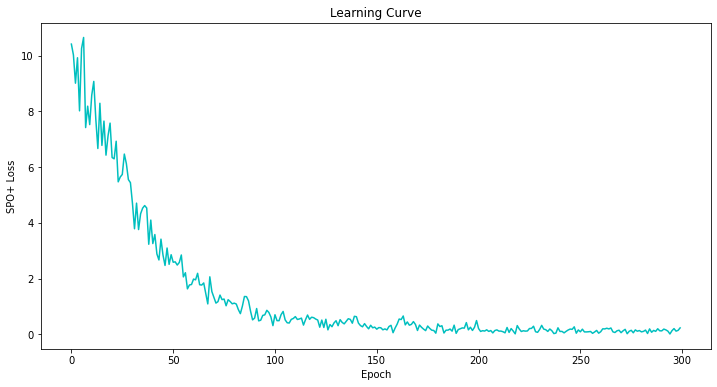

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np

In [25]:
# evaluate
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    loss.append(criterion.apply(sp_model, cp, c, w, z).mean().item())
print('Test Loss: {:.6f}'.format(np.mean(loss)))

Test Loss: 0.118588


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # predicy
    x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 3.56, 2.73, 2.34, 3.59, 2.70, 3.34, 2.62, 2.36, 3.81, 2.84, 3.34, 2.84, 3.23, 2.36, 3.71, 2.36, 2.87, 2.12, 1.64, 3.34, 2.84, 2.12, 2.47, 3.21, 3.06, 2.62, 3.71, 3.71, 1.86, 2.95, 1.75, 3.23, 1.75, 2.73, 2.34, 2.95, 2.62, 2.95, 2.00, 2.12
    Pred cost: -0.40, 1.32, -0.01, -0.33, -0.72, 1.22, -1.09, 2.20, -1.10, -0.18, 0.21, -0.41, 1.15, -0.69, 0.93, -0.73, -0.98, 0.33, -1.05, -0.13, -0.64, 0.38, 0.24, -0.88, -0.03, -0.15, 0.66, 0.16, -0.84, -0.03, -1.04, -0.49, -0.08, -0.31, -0.81, 0.25, 0.82, -0.02, -0.88, -0.20
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 18.61
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 18.61

Sample 1:
    True cost: 0.61, 1.95, 2.34, 1.30, 1.26, 0.45, 0.68, 1.08, 1.46, 1.97, 0.45, 0.83, 0.44, 1.08, 1.32, 1.08, 1.52, 2.19, 1.30, 0.45, 0.83, 2.1